In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns

In [2]:
df = pd.read_csv('dataset.csv')
df['NewExist'] = df['NewExist'].fillna(0)

features_of_interest = [
    'State','cat_activites', 'UrbanRural','LowDoc','bank_loan_float','SBA_loan_float','FranchiseCode','BankState','RevLineCr','Term','ApprovalFY',
    'MIS_Status',
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term'
    
]


ordinal_column = [
    'LowDoc'
]

categorical_column = [
    'State','cat_activites','FranchiseCode','BankState','RevLineCr',
]


target_name = "MIS_Status"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('MIS_Status', axis=1)
X_test = X_test.drop('MIS_Status', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [4]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),
    ],
    remainder="passthrough",
)

In [5]:



clf = make_pipeline(preprocessor,lgb.LGBMClassifier()) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans
clf.fit(X_train, y_train_encoded)

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.067584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2150
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 673
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'cat_activites',
                                                   'FranchiseCode', 'BankState',
                                                   'RevLineCr']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc']),
                                                 ('numeric', StandardScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [6]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', clf.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AUC-ROC score: 0.9777583347815546


c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


accuracy 0.9479075147080085
rappel 0.8154226333797998
f1_score 0.8460324764972718
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



In [7]:
#Dataframe pour les features of importances

df_rf = pd.DataFrame(clf[-1].feature_importances_,clf[0].get_feature_names_out())
df_rf=df_rf.transpose()
df_rf.columns

Index(['categorical__State_AK', 'categorical__State_AL',
       'categorical__State_AP', 'categorical__State_AR',
       'categorical__State_AZ', 'categorical__State_CA',
       'categorical__State_CO', 'categorical__State_CT',
       'categorical__State_DC', 'categorical__State_DE',
       ...
       'categorical__RevLineCr_T', 'categorical__RevLineCr_Y',
       'categorical__RevLineCr_`', 'categorical__RevLineCr_nan',
       'ordinal__LowDoc', 'numeric__bank_loan_float',
       'numeric__SBA_loan_float', 'numeric__Term', 'remainder__UrbanRural',
       'remainder__ApprovalFY'],
      dtype='object', length=2832)

In [17]:
# Création des sommes pour les features importances pour chaque variable catégorielle
liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)
    


['sum_State', 'sum_cat_activites', 'sum_UrbanRural', 'sum_LowDoc', 'sum_bank_loan_float', 'sum_SBA_loan_float', 'sum_FranchiseCode', 'sum_BankState', 'sum_RevLineCr', 'sum_Term', 'sum_ApprovalFY', 'sum_MIS_Status']


In [21]:
liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)

['sum_State', 'sum_cat_activites', 'sum_UrbanRural', 'sum_LowDoc', 'sum_bank_loan_float', 'sum_SBA_loan_float', 'sum_FranchiseCode', 'sum_BankState', 'sum_RevLineCr', 'sum_Term', 'sum_ApprovalFY', 'sum_MIS_Status']


In [22]:
df_rf_graphique = df_rf[liste_sum]

In [19]:
df_rf_graphique


,sum_State,sum_cat_activites,sum_UrbanRural,sum_LowDoc,sum_bank_loan_float,sum_SBA_loan_float,sum_FranchiseCode,sum_BankState,sum_RevLineCr,sum_Term,sum_ApprovalFY,sum_MIS_Status
0,5656,396,78,78,312,495,176,1936,812,3852,1083,0


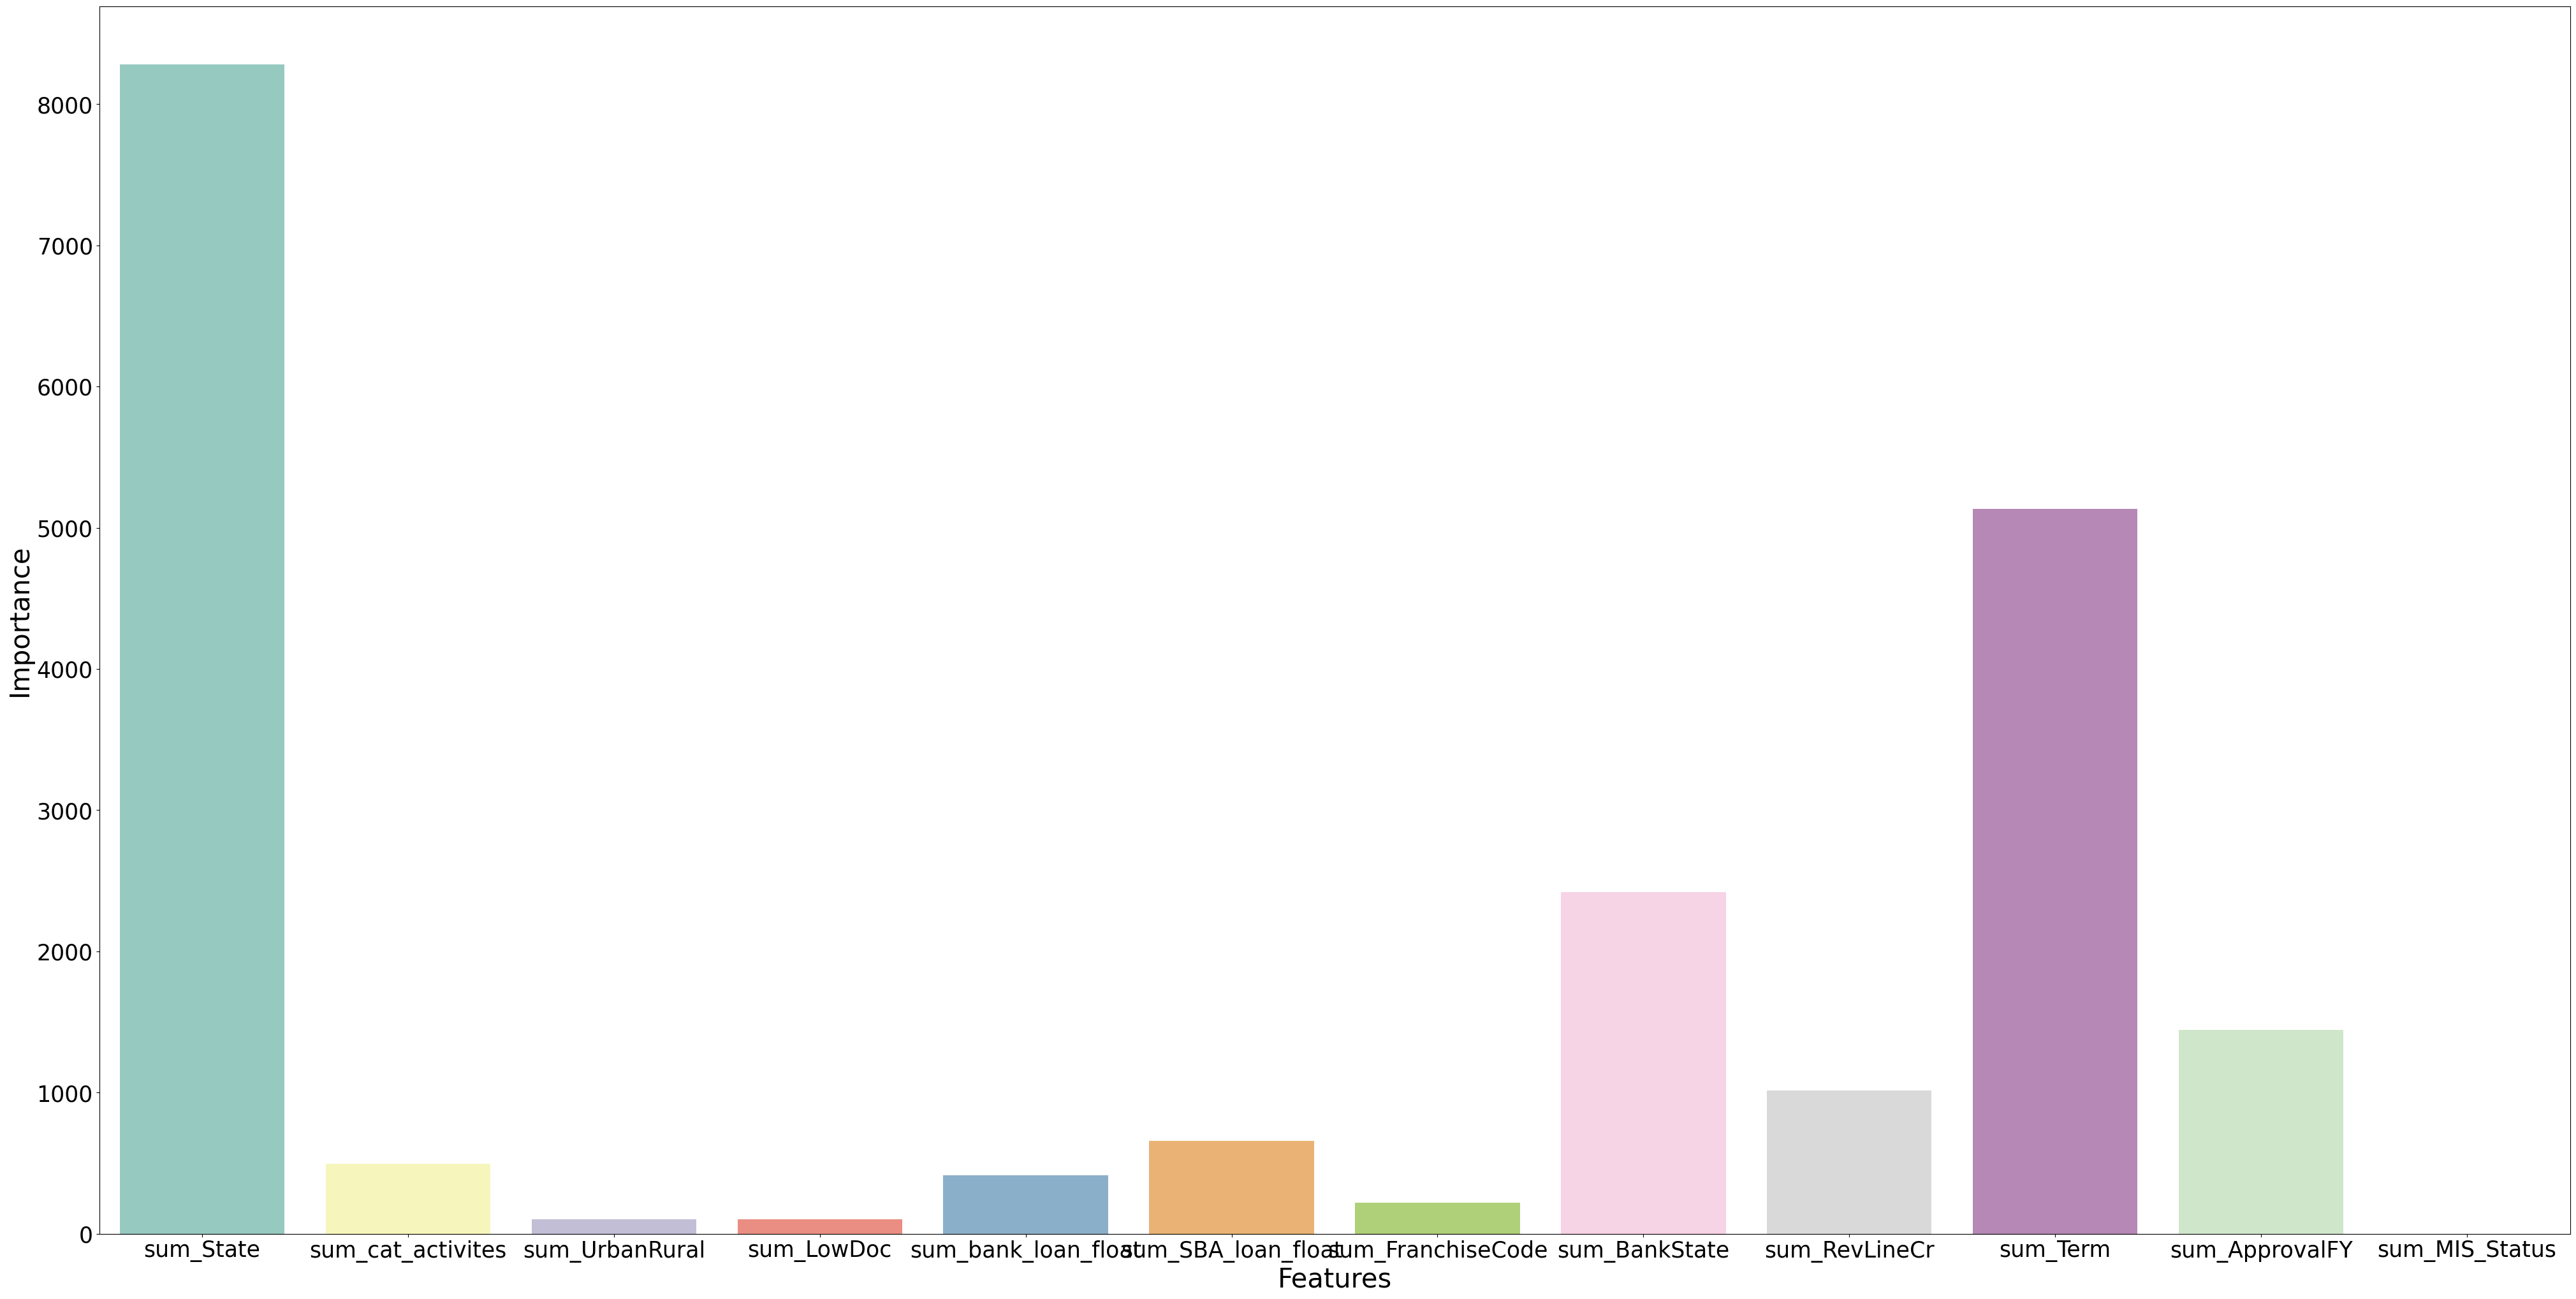

In [23]:

plt.figure(figsize=(50, 25))
sns.barplot(data=df_rf_graphique, palette="Set3")

# Augmenter la taille des labels des axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Augmenter la taille des ticks des axes
plt.tick_params(axis='both', labelsize=25)
plt.show()


In [13]:
y_pred = clf.predict(X_test)
y_pred

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([1, 0, 1, ..., 1, 1, 1], shape=(89917,))

In [14]:
import pickle
pickle.dump(clf,open('clf_lgbm.pkl','wb'))
